In [311]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fft import fft2, fftshift
from scipy.integrate import solve_ivp
from skimage import io
import struct

In [277]:
def lorenz_equations(state, sigma, rho, beta):
  x, y, z = state
  dx = sigma * (y - x)
  dy = x * (rho - z) - y
  dz = x * y - beta * z
  return [dx, dy, dz]

In [278]:
def solve_differential_equation(init_state, key_length, warmup_skip_count, sigma=10.0, rho=28.0, beta=8/3):
  # faza rozgrzewki, pobranie ostatniego punktu od którego rozpocznie
  # się właściwa faza wyznaczania wartości chaotycznych

  sol_warmup = solve_ivp(
    lambda _, y: lorenz_equations(y, sigma, rho, beta),
    t_span=[0, warmup_skip_count * 0.01],
    y0=init_state,
    method="RK45", # metoda Runge-Kutty'iego
  )
  last_warmup_point = sol_warmup.y[:, -1]

  # faza wyznaczania wartości chaotycznych od punktu last_warmup_point

  # długość dzielona przez 3, bo wyjście układu jest dla xyz
  t_end = int(np.ceil(key_length / 3))

  sol = solve_ivp(
    lambda _, y: lorenz_equations(y, sigma, rho, beta),
    t_span=[0, t_end * 0.01],
    y0=last_warmup_point, # punkt startowy po rozgrzewce
    method="RK45",
    t_eval=np.linspace(0, t_end * 0.01, t_end),
  )
  # spłaszcz do jednowymiarowej tablicy i odrzuć wartości spoza zakresu
  return sol.y.flatten()[:key_length]

In [279]:
def create_stream_key(solver_out):
  # pobierz jedynie wartości ułamkowe
  fractions_only = np.abs(solver_out - np.floor(solver_out))
  # przeskaluj o dużą wartość
  fractions_only *= 1e10
  # normalizuj do 8 bitów
  key_as_bytes = np.floor(fractions_only) % 256
  return key_as_bytes.astype(np.uint8)

In [280]:
def lorenz_variational(state, sigma, rho, beta):
  x, y, z = state[:3] # wektor stanu [x, y, z]
  d_vec = state[3:] # wektor zaburzenia [dx, dy, dz]

  # trajektoria główna
  main_trajectory = lorenz_equations((x, y, z), sigma, rho, beta)

  # macierz Jakobiego
  J = np.array([
    [-sigma, sigma, 0],
    [rho - z, -1, -x],
    [y, x, -beta]
  ])
  d_vecdt = J @ d_vec # J * d_vec (równania wariacyjne)

  return np.concatenate((main_trajectory, d_vecdt))

def calculate_warmup_skip_count(init_state, warmup_time=100, n_steps=15000, tau=0.1, key_step=0.01, safe_mult=10,
                                sigma=10.0, rho=28.0, beta=8/3):
  sol_warmup = solve_ivp(
    lambda _, y: lorenz_equations(y, sigma, rho, beta),
    t_span=[0, warmup_time],
    y0=init_state,
    method="RK45",
  )
  main_trajectory_start = sol_warmup.y[:, -1]

  # wektor zaburzenia tylko dla parametru x
  perturbation_start = np.array([1.0, 0.0, 0.0])
  combined_state = np.concatenate(
    (main_trajectory_start, perturbation_start)
  )

  lapunov_sum = 0.0
  for _ in range(n_steps):
    sol_step = solve_ivp(
      lambda _, y: lorenz_variational(y, sigma, rho, beta),
      t_span=[0, tau],
      y0=combined_state,
      t_eval=[tau],
    )
    combined_state = sol_step.y[:, 0]
    final_perturbation = combined_state[3:]

    # obliczenie długości wektora zaburzenia
    norm = np.linalg.norm(final_perturbation)
    if norm > 0:
      lapunov_sum += np.log(norm)

    # renormalizacja, wektor początkowy następnego kroku
    combined_state[3:] = final_perturbation / norm

  mle = lapunov_sum / (n_steps * tau) # maksymalny wykładnik Lapunowa
  lyapunov_time = 1 / mle # czas Lapunowa

  # obliczenie wartości do odrzucenia mnożąc czas Lapunowa
  # przez bezpieczny mnożnik
  return int(np.ceil(lyapunov_time * safe_mult / key_step))

In [281]:
def add_nonce_to_init_state(init_state, nonce):
  key_string = str(init_state)

  # łączenie klucza (init_state) z nonce oddzielając separatorem
  data_to_hash = key_string.encode('utf-8') + b"|" + nonce

  # hashowanie połączonego stringa
  h = hashlib.sha256(data_to_hash)
  digest = h.digest()

  # bezpieczne zakresy dla warunków początkowych
  min_val, max_val = -20.0, 20.0

  coords = []
  # 3 części po 8 bajtów, reszta ignorowana
  for i in range(3):
    chunk = digest[i*8 : (i+1)*8] # jedna współrzędna 8 bajtów
    # konwersja na duża liczbę całkowitą (big-endian)
    large_int = struct.unpack('>Q', chunk)[0]

    # normalizacja do zakresu 0 do 1, wartość maksymalna: 2^64 - 1
    normalized_val = large_int / (2**64 - 1)

    # skalowanie do przyjętego zakresu
    final_coord = min_val + (max_val - min_val) * normalized_val
    coords.append(final_coord)

  return coords

In [ ]:
def encrypt_decrypt(data, init_seed, nonce, data_length=None):
  if not data_length:
    data_length = len(data)

  # dodaj do sekretnego klucza (parametry początkowe) wartość nonce
  key_with_nonce = add_nonce_to_init_state(init_seed, nonce)

  # oblicz ilość elementów początkowych elementów do pominięcia
  skip_length = calculate_warmup_skip_count(key_with_nonce)

  # rozwiązanie układu równań Lorenza i utworzenie
  # strumieniowego klucza szyfrującego jako tablicy bajtów
  out = solve_differential_equation(init_seed, data_length, skip_length)
  key_stream = create_stream_key(out)

  encrypted_decrypted_data = [
    b_data ^ b_key for b_data, b_key in zip(data, key_stream)
  ]
  return bytes(encrypted_decrypted_data)

def encrypt(decrypted_data, init_seed, data_length=None):
  # pseudolosowa wartość generowana przy każdym szyfrowaniu
  nonce = os.urandom(16)
  encrypted_data = encrypt_decrypt(decrypted_data, init_seed, nonce, data_length)

  return nonce, encrypted_data

def decrypt(encrypted_data, init_seed, nonce, data_length=None):
  decrypted_data = encrypt_decrypt(encrypted_data, init_seed, nonce, data_length)
  return decrypted_data

In [ ]:
init_state = [2.3, 3.23, 1.16]

data = "Sekretny szyfr"
data = data.encode("utf-8")

nonce, encrypted_data = encrypt(data, init_state)
print(f"encrypted: {encrypted_data.hex()}")

decrypted_data = decrypt(encrypted_data, init_state, nonce)
print(f"decrypted: {decrypted_data.decode("utf-8")}")

encrypted: d99bd7ae3a1e6b6a425d18f7b40a
decrypted: Sekretny szyfr


In [308]:
def get_magnitude_spectrum(image):
  f_transform = fft2(image)
  # przesunięcie DC do środka obrazu
  f_transform_shifted = fftshift(f_transform)
  # +1 aby uniknąć log(0)
  return np.log(np.abs(f_transform_shifted) + 1)

In [325]:
init_state = [2.3, 3.23, 1.16]

image = io.imread("../input/306052.png")

I = np.array(image)
I_1d = I.flatten() # spłaszczanie obrazu do jednego wymiaru

nonce, encrypted_image_1d = encrypt(I_1d, init_state)
decrypted_image_1d = decrypt(encrypted_image_1d, init_state, nonce)

# rekonstrukcja do 2 wymiarów (w, h)
I_encrypted = np.frombuffer(encrypted_image_1d, dtype=np.uint8).reshape(I.shape)
I_decrypted = np.frombuffer(decrypted_image_1d, dtype=np.uint8).reshape(I.shape)

I_mag_spect = get_magnitude_spectrum(I)
I_encrypted_mag_spect = get_magnitude_spectrum(I_encrypted)
I_decrypted_mag_spect = get_magnitude_spectrum(I_decrypted)

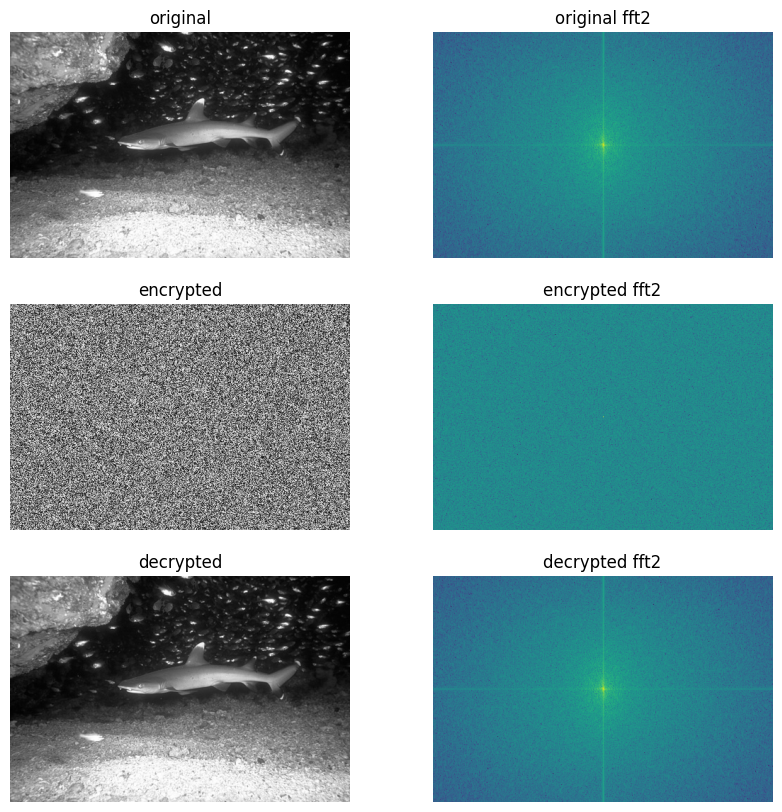

In [326]:
fig = plt.figure(figsize=(10, 10))

raw_image = fig.add_subplot(321)
raw_image_mag = fig.add_subplot(322)
encrypted_image = fig.add_subplot(323)
encrypted_image_mag = fig.add_subplot(324)
decrypted_image = fig.add_subplot(325)
decrypted_image_mag = fig.add_subplot(326)

raw_image.imshow(I, cmap="gray", aspect="equal")
raw_image.set_title("original")
raw_image.axis("off")

encrypted_image.imshow(I_encrypted, cmap="gray", aspect="equal")
encrypted_image.set_title("encrypted")
encrypted_image.axis("off")

decrypted_image.imshow(I_decrypted, cmap="gray", aspect="equal")
decrypted_image.set_title("decrypted")
decrypted_image.axis("off")

raw_image_mag.imshow(I_mag_spect, aspect="equal")
raw_image_mag.set_title("original fft2")
raw_image_mag.axis("off")

encrypted_image_mag.imshow(I_encrypted_mag_spect, aspect="equal")
encrypted_image_mag.set_title("encrypted fft2")
encrypted_image_mag.axis("off")

decrypted_image_mag.imshow(I_decrypted_mag_spect, aspect="equal")
decrypted_image_mag.set_title("decrypted fft2")
decrypted_image_mag.axis("off")

plt.grid(True)
plt.show()